Calculate shannon diversity index to investigate if there are diverse or dominant clones in the mouse lungs

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#print versions of libraries
import sys 
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

merged_df = pd.read_csv("./MFP_IV_combined_raw_data.csv")
#convert column clone_type insto string
merged_df['clone_type'] = merged_df['clone_type'].astype(str)

#define a function to get get radius given volume 
def get_radius(volume):
    return (3*volume/(4*np.pi))**(1/3)

#add a column for radius
merged_df['radius_met'] = merged_df['Volume corrected'].apply(get_radius)
#normalized min distance to radius_met
merged_df['min_dist_norm'] = merged_df['min_dist'] / merged_df['radius_met']
merged_df['total_lung_no_vessel'] = merged_df['total_lung_volume'] - merged_df['vessel_volume']
merged_df["vol_norm"] = merged_df["Volume corrected"] / merged_df["total_lung_volume"]
merged_df["vol_norm_no_vessel"] = merged_df["Volume corrected"] / merged_df['total_lung_no_vessel']

merged_df.head()


Python version: 3.10.14 | packaged by Anaconda, Inc. | (main, Mar 21 2024, 16:20:14) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.2.1
Seaborn version: 0.13.2
Numpy version: 1.23.4
Matplotlib version: 3.8.4


C:\Users\rajasekhar.p\AppData\Local\Temp\ipykernel_11812\3697179934.py:14: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("./MFP_IV_combined_raw_data.csv")


,MET_ID,1,10,11,100,101,110,111,Volume corrected,min_dist,...,vessel_surface_area,minor_axis,major_axis,elongation,met_type_cat,radius_met,min_dist_norm,total_lung_no_vessel,vol_norm,vol_norm_no_vessel
0,28.0,0.011735,0.167993,0.0,0.511050,0.000000,0.309223,0.0,2.202260e+08,0.000000,...,1.510170e+08,161.040177,337.000000,2.092645,polyclonal,374.622027,0.000000,2.690552e+10,0.007934,0.008185
1,50.0,0.998808,0.001192,0.0,0.000000,0.000000,0.000000,0.0,6.563523e+04,282.432010,...,1.510170e+08,13.000000,18.336258,1.410481,polyclonal,25.023581,11.286634,2.690552e+10,0.000002,0.000002
2,89.0,0.175399,0.099498,0.0,0.545721,0.179381,0.000000,0.0,1.246517e+08,15.761827,...,1.510170e+08,167.418006,376.000000,2.245876,polyclonal,309.886884,0.050863,2.690552e+10,0.004491,0.004633
3,119.0,0.974494,0.001366,0.0,0.024140,0.000000,0.000000,0.0,1.326004e+06,0.000000,...,1.510170e+08,37.469744,55.000000,1.467851,polyclonal,68.153062,0.000000,2.690552e+10,0.000048,0.000049
4,125.0,0.975769,0.000219,0.0,0.024012,0.000000,0.000000,0.0,1.016321e+07,0.000000,...,1.510170e+08,76.533946,111.000000,1.450337,polyclonal,134.373652,0.000000,2.690552e+10,0.000366,0.000378


Calculate the shannon diversity index (SDI) for mouse lungs

If the lung has more diverse clones, then it will have a higher SDI. If it has a few dominant clones, it will have a lower SDI

This takes into account monoclonal and polyclonal METs as well.. 


In [2]:
#Function to calculate shannon diversity index
def shannon_diversity_index(df):
    #get the total number of values
    total = len(df)
    #initialize the shannon index
    shannon_index = 0
    #loop through each unique value
    for value in df.unique():
        #get the proportion of the value
        p = len(df[df == value]) / total
        #add the value to the shannon index
        shannon_index += p * np.log(p)
    #return the negative shannon index
    return -shannon_index

In [18]:
#apply a shannon diversity index function to clone_type column and create a new column. Group it by id
shannon_div = merged_df.groupby(['treatment','id'])['clone_type'].transform(shannon_diversity_index)
#rename clone_type column to shannon_div
shannon_div = shannon_div.rename('shannon_div')
#add id column
shannon_div = pd.concat([merged_df[['id','treatment']], shannon_div], axis=1)
#get unique values of id and shannon_div
shannon_div = shannon_div.drop_duplicates().reset_index(drop=True)
shannon_div

,id,treatment,shannon_div
0,1064,IV,1.479085
1,1066,IV,1.116337
2,1067,MFP,1.072888
3,1069,MFP,1.558371
4,1070,MFP,0.629349
5,1381,MFP,1.698220
6,883,IV,0.849124
7,934,IV,1.414846
8,935,IV,0.102149


C:\Users\rajasekhar.p\AppData\Local\Temp\ipykernel_11812\3608417856.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=shannon_div, hue='treatment', y='shannon_div', dodge=True, color="black",legend=False)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


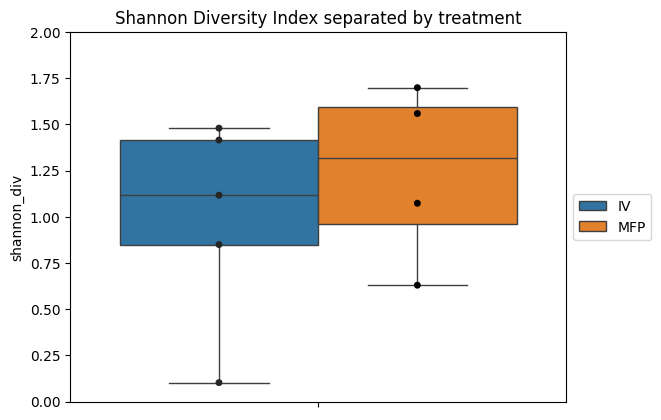

In [19]:
sns.boxplot(data=shannon_div, hue='treatment', y='shannon_div')
sns.swarmplot(data=shannon_div, hue='treatment', y='shannon_div', dodge=True, color="black",legend=False)
plt.ylim(0,2)
#legend outside plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Shannon Diversity Index separated by treatment")

plt.savefig("./final_graphs/supplementary/suppfig3_shannon_diversity_treatment.eps", format="eps",dpi=300)

In [20]:
from scipy.stats import ttest_ind,ttest_rel
#perform a t-test on the shannon diversity index between the two groups

shannon_idx_mfp = shannon_div[shannon_div['treatment'] == 'MFP']['shannon_div'].unique()
shannon_idx_iv = shannon_div[shannon_div['treatment'] == 'IV']['shannon_div'].unique()

print(ttest_ind(shannon_idx_iv,shannon_idx_mfp))


TtestResult(statistic=-0.6976962776641318, pvalue=0.5078719611513762, df=7.0)


We have looked at overall SDI. But what about the SDI for monoclonal and polyclonal METs?

Are monoclonal clones diverse or not compared to polyclonal and what about comparing it across treatments?

In [23]:
#apply a shannon diversity index function to clone_type column and create a new column. Group it by id
shannon_div_met_type = merged_df.groupby(['treatment','id','met_type_cat'])['clone_type'].transform(shannon_diversity_index)
#rename clone_type column to shannon_div
shannon_div_met_type = shannon_div_met_type.rename('shannon_div_met_type')
#add id column
shannon_div_met_type = pd.concat([merged_df[['id','treatment','met_type_cat']], shannon_div_met_type], axis=1)
#get unique values of id and shannon_div
shannon_div_met_type = shannon_div_met_type.drop_duplicates().reset_index(drop=True)
shannon_div_met_type

,id,treatment,met_type_cat,shannon_div_met_type
0,1064,IV,polyclonal,1.774457
1,1064,IV,monoclonal,0.945823
2,1066,IV,polyclonal,2.058568
3,1066,IV,monoclonal,0.767249
4,1067,MFP,monoclonal,0.880404
5,1067,MFP,polyclonal,1.312126
6,1069,MFP,polyclonal,2.156401
7,1069,MFP,monoclonal,0.943187
8,1070,MFP,polyclonal,1.472713
9,1070,MFP,monoclonal,0.327223


C:\Users\rajasekhar.p\AppData\Local\Temp\ipykernel_11812\3592992324.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=shannon_div_met_type, x='treatment', y='shannon_div_met_type', hue='met_type_cat', dodge=True, color="black",legend=False)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


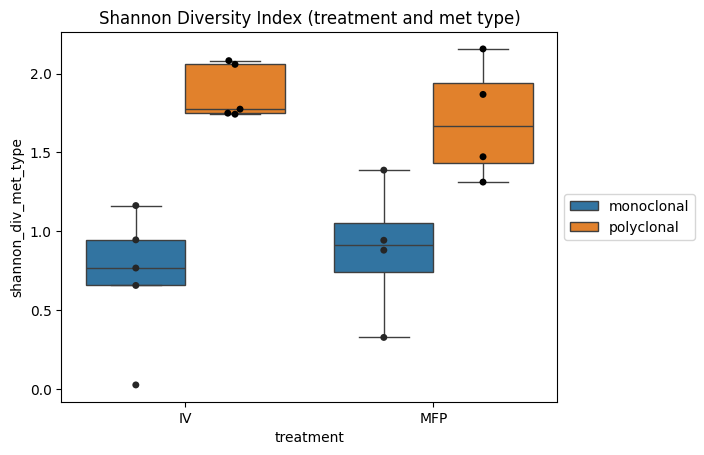

In [30]:
#plot shannon diversity index separated by treatment and metastasis type
#convert met_type_cat to category
shannon_div_met_type['met_type_cat'] = shannon_div_met_type['met_type_cat'].astype('category')
sns.boxplot(data=shannon_div_met_type, x='treatment', y='shannon_div_met_type', hue='met_type_cat',showfliers=False)
sns.swarmplot(data=shannon_div_met_type, x='treatment', y='shannon_div_met_type', hue='met_type_cat', dodge=True, color="black",legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Shannon Diversity Index (treatment and met type)")
plt.savefig("./final_graphs/supplementary/suppfig3_shannon_diversity_treatment_met_type.eps", format="eps",dpi=300)


In [33]:
#stats ttest_rel for monoclonal vs poly for each treatment

mono_iv = shannon_div_met_type[(shannon_div_met_type['treatment'] == 'IV') & (shannon_div_met_type['met_type_cat'] == 'monoclonal')]['shannon_div_met_type']
poly_iv = shannon_div_met_type[(shannon_div_met_type['treatment'] == 'IV') & (shannon_div_met_type['met_type_cat'] == 'polyclonal')]['shannon_div_met_type']

mono_mfp = shannon_div_met_type[(shannon_div_met_type['treatment'] == 'MFP') & (shannon_div_met_type['met_type_cat'] == 'monoclonal')]['shannon_div_met_type']
poly_mfp = shannon_div_met_type[(shannon_div_met_type['treatment'] == 'MFP') & (shannon_div_met_type['met_type_cat'] == 'polyclonal')]['shannon_div_met_type']

print("T-test for IV treatment monoclonal vs polyclonal")
print(ttest_rel(mono_iv,poly_iv))

print("\nT-test for MFP treatment monoclonal vs polyclonal")
print(ttest_rel(mono_mfp,poly_mfp))


T-test for IV treatment monoclonal vs polyclonal
TtestResult(statistic=-7.342423993965497, pvalue=0.0018319346305922036, df=4)

T-test for MFP treatment monoclonal vs polyclonal
TtestResult(statistic=-3.9021009805194042, pvalue=0.029879097605433478, df=3)
